In [1]:
import sys
sys.path.append("../")
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import ssl
import urllib.request
import requests
import json
from datetime import datetime
from pathlib import Path
import matplotlib.pyplot as plt
from itertools import chain
from bids.modeling import BIDSStatsModelsGraph
from bids.layout import BIDSLayout, BIDSLayoutIndexer
from bids.tests import get_test_data_path
from os.path import join
from nilearn import image
from nilearn.interfaces.bids import parse_bids_filename
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix, view_img
from scripts.utils import generate_tablecontents, get_bidstats_events, similarity_boldstand_metrics, get_low_quality_subs, pull_contrast_conditions_spec, eval_missing_events
from concurrent.futures import ProcessPoolExecutor
from functools import partial
import json
import warnings
import matplotlib
import shutil
warnings.filterwarnings("ignore", category=matplotlib.MatplotlibDeprecationWarning)


In [186]:
generate_tablecontents("transformations.ipynb")            

# Table of Contents

- [ Fitlins Transformations: Subject-Level Modeling](#-Fitlins-Transformations-Subject-Level-Modeling)
  - [ Focus on Subject-Level Models](#-Focus-on-Subject-Level-Models)
  - [ PyBIDS Transformations Summary](#-PyBIDS-Transformations-Summary)
- [ Spec Files and Model Outputs](#-Spec-Files-and-Model-Outputs)
  - [ ds003425: Applying Factors, Convolve and Filter](#-ds003425-Applying-Factors-Convolve-and-Filter)
    - [ Apply *Factor* to trial_type](#-Apply-Factor-to-trial_type)
    - [ Convolve trial_type Factors](#-Convolve-trial_type-Factors)
    - [ Create New Regressor using *Filter*](#-Create-New-Regressor-using-Filter)
  - [ ds004711: Applying DropNA, Rename, Factors, Convolve](#-ds004711-Applying-DropNA-Rename-Factors-Convolve)
    - [ Rename, Factor & Rename](#-Rename-Factor--Rename)
    - [ Add DropNA](#-Add-DropNA)
  - [ ds001734: Demean, Rename, Replace, Assign Duration / Amplitude](#-ds001734-Demean-Rename-Replace-Assign-Duration--Amplitude)
    - [ Rename / Replace](#-Rename--Replace)
    - [ Demean gain / loss](#-Demean-gain--loss)
    - [ Assign Amplitude & Duration](#-Assign-Amplitude--Duration)
    - [ Final NARPS Model Spec](#-Final-NARPS-Model-Spec)
  - [ Inconsistent Runs files per subject](#-Inconsistent-Runs-files-per-subject)
  - [ Missing subjects for session](#-Missing-subjects-for-session)
  - [ Error in onset / duration / type column](#-Error-in-onset--duration--type-column)
- [ Pilot Errors](#-Pilot-Errors)
    - [ Inconsistent Subjects / Runs / Sessions](#-Inconsistent-Subjects--Runs--Sessions)
    - [ Grouping entity error](#-Grouping-entity-error)
    - [ Plotting contrast matrix error](#-Plotting-contrast-matrix-error)
    - [ Failed finding 'trial_type'](#-Failed-finding-trial_type)

# Group Statistical Models

## One Sample T-test

## One Sample T-test w/ Covariate

## One Sample Paired T-test (runs)

## Two-sample T-test

## Two-sample T-test w/ Covariate

## 2+ Group ANOVA

In [6]:
study_id = 'ds000171'
taskname = "music"
bids_inp = f"/oak/stanford/groups/russpold/data/openneuro_fitlins/input/{study_id}"


In [3]:
bids_layout = BIDSLayout(bids_inp,derivatives=False)
events = bids_layout.get(task=taskname, suffix="events", extension=".tsv")
bids_layout.get_sessions(task=taskname), len(events)

([], 0)

In [76]:
# Group Level, One sample T
# https://bidspm.readthedocs.io/en/latest/stats/bids_stats_model.html#transformation'
test_spec = {
  "Name": "ds000171",
  "BIDSModelVersion": "1.0.0",
  "Input": {
    "subject": [
      "control01",
      "control02",
      "control03",
      "control04",
      "control05",
      "control06",
      "control07",
      "control08",
      "control09",
      "control10",
      "control11",
      "control12",
      "control13",
      "control14",
      "control15",
      "control16",
      "control17",
      "control18",
      "control19",
      "control20",
      "mdd01",
      "mdd02",
      "mdd03",
      "mdd04",
      "mdd05",
      "mdd06",
      "mdd07",
      "mdd08",
      "mdd09",
      "mdd10",
      "mdd11",
      "mdd12",
      "mdd13",
      "mdd14",
      "mdd15",
      "mdd16",
      "mdd17",
      "mdd18",
      "mdd19"
    ],
    "task": [
      "music"
    ],
    "run": [
      1,
      2,
      3,
      4,
      5
    ]
  },
  "Nodes": [
    {
      "Level": "Run",
      "Name": "run_level",
      "GroupBy": [
        "run",
        "subject"
      ],
      "Transformations": {
        "Transformer": "pybids-transforms-v1",
        "Instructions": [
          {
            "Name": "Factor",
            "Input": [
              "trial_type"
            ]
          },
          {
            "Name": "Convolve",
            "Model": "spm",
            "Input": [
              "trial_type.*"
            ]
          }
        ]
      },
      "Model": {
        "X": [
          1,
          "trial_type.*",
          "trans_*",
          "rot_*",
          "cosine*"
        ],
        "Type": "glm"
      },
      "Contrasts": [
        {
          "Name": "musicvsounds",
          "ConditionList": [
            "trial_type.positive_music",
            "trial_type.negative_music",
            "trial_type.tones"
          ],
          "Weights": [
            0.5,
            0.5,
            -1
          ],
          "Test": "t"
        },
        {
          "Name": "posmusicvnegmusic",
          "ConditionList": [
            "trial_type.positive_music",
            "trial_type.negative_music"
          ],
          "Weights": [
            1,
            -1
          ],
          "Test": "t"
        },
        {
          "Name": "negmusicvsounds",
          "ConditionList": [
            "trial_type.negative_music",
            "trial_type.tones"
          ],
          "Weights": [
            1,
            -1
          ],
          "Test": "t"
        },
        {
          "Name": "posmusicvsounds",
          "ConditionList": [
            "trial_type.positive_music",
            "trial_type.tones"
          ],
          "Weights": [
            1,
            -1
          ],
          "Test": "t"
        },
        {
          "Name": "posmusic",
          "ConditionList": [
            "trial_type.positive_music"
          ],
          "Weights": [
            1
          ],
          "Test": "t"
        },
        {
          "Name": "negmusic",
          "ConditionList": [
            "trial_type.negative_music"
          ],
          "Weights": [
            1
          ],
          "Test": "t"
        },
        {
          "Name": "tones",
          "ConditionList": [
            "trial_type.tones"
          ],
          "Weights": [
            1
          ],
          "Test": "t"
        },
        {
          "Name": "response",
          "ConditionList": [
            "trial_type.response"
          ],
          "Weights": [
            1
          ],
          "Test": "t"
        }
      ]
    },
    {
      "Level": "Subject",
      "Name": "subject_level",
      "GroupBy": [
        "subject",
        "contrast"
      ],
      "Model": {
        "X": [
          1
        ],
        "Type": "glm"
      },
      "DummyContrasts": {
        "Test": "t"
      }
    },
    {
      "Level": "Dataset",
      "Name": "data_level",
      "GroupBy": [
        "contrast"
      ],

      "Transformations": {
        "Transformer": "pybids-transforms-v1",
        "Instructions": [
          {
            "Name": "Factor",
            "Input": [
              "group"
            ]
          }
        ]
      },
      "Model": {
        "X": [
          1
        ],
        "Type": "glm"
      },
      "DummyContrasts": {
        "Test": "t"
      }
    }
  ]
}

TR = 2
volumes = 300
eventsdf_ex, root_mod = get_bidstats_events(bids_inp, test_spec, scan_length=volumes*TR, ignored=[r"sub-.*_physio\.(json|tsv\.gz)"], return_events_num=0)
outputs = root_mod.run(
    group_by=root_mod.group_by, force_dense=False, transformation_history=True
)


In [180]:
# group, two sample t-test
test_spec = {
  "Name": "ds000171",
  "BIDSModelVersion": "1.0.0",
  "Input": {
    "subject": [
      "control01",
      "control02",
      "control03",
      "control04",
      "control05",
      "control06",
      "control07",
      "control08",
      "control09",
      "control10",
      "control11",
      "control12",
      "control13",
      "control14",
      "control15",
      "control16",
      "control17",
      "control18",
      "control19",
      "control20",
      "mdd01",
      "mdd02",
      "mdd03",
      "mdd04",
      "mdd05",
      "mdd06",
      "mdd07",
      "mdd08",
      "mdd09",
      "mdd10",
      "mdd11",
      "mdd12",
      "mdd13",
      "mdd14",
      "mdd15",
      "mdd16",
      "mdd17",
      "mdd18",
      "mdd19"
    ],
    "task": [
      "music"
    ],
    "run": [
      1,
      2,
      3,
      4,
      5
    ]
  },
  "Nodes": [
    {
      "Level": "Run",
      "Name": "run_level",
      "GroupBy": [
        "run",
        "subject"
      ],
      "Transformations": {
        "Transformer": "pybids-transforms-v1",
        "Instructions": [
          {
            "Name": "Factor",
            "Input": [
              "trial_type"
            ]
          },
          {
            "Name": "Convolve",
            "Model": "spm",
            "Input": [
              "trial_type.*"
            ]
          }
        ]
      },
      "Model": {
        "X": [
          1,
          "trial_type.*",
          "trans_*",
          "rot_*",
          "cosine*"
        ],
        "Type": "glm"
      },
      "Contrasts": [
        {
          "Name": "musicvsounds",
          "ConditionList": [
            "trial_type.positive_music",
            "trial_type.negative_music",
            "trial_type.tones"
          ],
          "Weights": [
            0.5,
            0.5,
            -1
          ],
          "Test": "t"
        },
        {
          "Name": "posmusicvnegmusic",
          "ConditionList": [
            "trial_type.positive_music",
            "trial_type.negative_music"
          ],
          "Weights": [
            1,
            -1
          ],
          "Test": "t"
        },
        {
          "Name": "negmusicvsounds",
          "ConditionList": [
            "trial_type.negative_music",
            "trial_type.tones"
          ],
          "Weights": [
            1,
            -1
          ],
          "Test": "t"
        },
        {
          "Name": "posmusicvsounds",
          "ConditionList": [
            "trial_type.positive_music",
            "trial_type.tones"
          ],
          "Weights": [
            1,
            -1
          ],
          "Test": "t"
        },
        {
          "Name": "posmusic",
          "ConditionList": [
            "trial_type.positive_music"
          ],
          "Weights": [
            1
          ],
          "Test": "t"
        },
        {
          "Name": "negmusic",
          "ConditionList": [
            "trial_type.negative_music"
          ],
          "Weights": [
            1
          ],
          "Test": "t"
        },
        {
          "Name": "tones",
          "ConditionList": [
            "trial_type.tones"
          ],
          "Weights": [
            1
          ],
          "Test": "t"
        },
        {
          "Name": "response",
          "ConditionList": [
            "trial_type.response"
          ],
          "Weights": [
            1
          ],
          "Test": "t"
        }
      ]
    },
    {
      "Level": "Subject",
      "Name": "subject_level",
      "GroupBy": [
        "subject",
        "contrast"
      ],
      "Model": {
        "X": [
          1
        ],
        "Type": "glm"
      },
      "DummyContrasts": {
        "Test": "t"
      }
    },
    {
      "Level": "Dataset",
      "Name": "twosample_t", 
      "GroupBy": [
        "contrast"
      ],
      "Transformations": {
        "Transformer": "pybids-transforms-v1",
        "Instructions": [
          {
            "Name": "Factor",
            "Input": [
              "group"
            ]
          }
        ]
      },
      "Model": {
        "X": [
          1,
          "group.*"
        ],
        "Type": "glm"
      },
      "Contrasts": [
        {
          "Name": "control_vs_mdd",
          "ConditionList": [
            "group.control",
            "group.mdd"
          ],
          "Weights": [
            1,
            -1
          ],
          "Test": "t"
        },
        {
          "Name": "mdd_vs_control", 
          "ConditionList": [
            "group.control",
            "group.mdd"
          ],
          "Weights": [
            -1,
            1
          ],
          "Test": "t"
        }
      ]
    }
  ]
}

TR = 2
volumes = 300
eventsdf_ex, root_mod = get_bidstats_events(bids_inp, test_spec, scan_length=volumes*TR, ignored=[r"sub-.*_physio\.(json|tsv\.gz)"], return_events_num=0)
outputs = root_mod.run(
    group_by=root_mod.group_by, force_dense=False, transformation_history=True
)

In [18]:

test_spec = {
  "Name": "ds000171",
  "BIDSModelVersion": "1.0.0",
  "Input": {
    "subject": [
      "control01",
      "control02",
      "control03",
      "control04",
      "control05",
      "control06",
      "control07",
      "control08",
      "control09",
      "control10",
      "control11",
      "control12",
      "control13",
      "control14",
      "control15",
      "control16",
      "control17",
      "control18",
      "control19",
      "control20",
      "mdd01",
      "mdd02",
      "mdd03",
      "mdd04",
      "mdd05",
      "mdd06",
      "mdd07",
      "mdd08",
      "mdd09",
      "mdd10",
      "mdd11",
      "mdd12",
      "mdd13",
      "mdd14",
      "mdd15",
      "mdd16",
      "mdd17",
      "mdd18",
      "mdd19"
    ],
    "task": [
      "music"
    ],
    "run": [
      1,
      2,
      3,
      4,
      5
    ]
  },
  "Nodes": [
    {
      "Level": "Run",
      "Name": "run_level",
      "GroupBy": [
        "run",
        "subject"
      ],
      "Transformations": {
        "Transformer": "pybids-transforms-v1",
        "Instructions": [
          {
            "Name": "Factor",
            "Input": [
              "trial_type"
            ]
          },
          {
            "Name": "Convolve",
            "Model": "spm",
            "Input": [
              "trial_type.*"
            ]
          }
        ]
      },
      "Model": {
        "X": [
          1,
          "trial_type.*",
          "trans_*",
          "rot_*",
          "cosine*"
        ],
        "Type": "glm"
      },
      "Contrasts": [
        {
          "Name": "musicvsounds",
          "ConditionList": [
            "trial_type.positive_music",
            "trial_type.negative_music",
            "trial_type.tones"
          ],
          "Weights": [
            0.5,
            0.5,
            -1
          ],
          "Test": "t"
        },
        {
          "Name": "posmusicvnegmusic",
          "ConditionList": [
            "trial_type.positive_music",
            "trial_type.negative_music"
          ],
          "Weights": [
            1,
            -1
          ],
          "Test": "t"
        },
        {
          "Name": "negmusicvsounds",
          "ConditionList": [
            "trial_type.negative_music",
            "trial_type.tones"
          ],
          "Weights": [
            1,
            -1
          ],
          "Test": "t"
        },
        {
          "Name": "posmusicvsounds",
          "ConditionList": [
            "trial_type.positive_music",
            "trial_type.tones"
          ],
          "Weights": [
            1,
            -1
          ],
          "Test": "t"
        },
        {
          "Name": "posmusic",
          "ConditionList": [
            "trial_type.positive_music"
          ],
          "Weights": [
            1
          ],
          "Test": "t"
        },
        {
          "Name": "negmusic",
          "ConditionList": [
            "trial_type.negative_music"
          ],
          "Weights": [
            1
          ],
          "Test": "t"
        },
        {
          "Name": "tones",
          "ConditionList": [
            "trial_type.tones"
          ],
          "Weights": [
            1
          ],
          "Test": "t"
        },
        {
          "Name": "response",
          "ConditionList": [
            "trial_type.response"
          ],
          "Weights": [
            1
          ],
          "Test": "t"
        }
      ]
    },
    {
      "Level": "Subject",
      "Name": "subject_level",
      "GroupBy": [
        "subject",
        "contrast"
      ],
      "Model": {
        "X": [
          1
        ],
        "Type": "glm"
      },
      "DummyContrasts": {
        "Test": "t"
      }
    },
    {
      "Level": "Dataset",
      "Name": "data_level",
      "GroupBy": [
        "contrast"
      ],
      "Model": {
        "X": [
          1
        ],
        "Type": "glm"
      },
      "DummyContrasts": {
        "Test": "t"
      }
    }
  ]
}

TR = 2
volumes = 300
eventsdf_ex, root_mod = get_bidstats_events(bids_inp, test_spec, scan_length=volumes*TR, ignored=[r"sub-.*_physio\.(json|tsv\.gz)"], return_events_num=0)
outputs = root_mod.run(
    group_by=root_mod.group_by, force_dense=False, transformation_history=True
)


In [ ]:
# One-way anova >2 groups
test_spec = {
  "Name": "ds000171",
  "BIDSModelVersion": "1.0.0",
  "Input": {
    "subject": [
      "control01",
      "control02",
      "control03",
      "control04",
      "control05",
      "control06",
      "control07",
      "control08",
      "control09",
      "control10",
      "control11",
      "control12",
      "control13",
      "control14",
      "control15",
      "control16",
      "control17",
      "control18",
      "control19",
      "control20",
      "mdd01",
      "mdd02",
      "mdd03",
      "mdd04",
      "mdd05",
      "mdd06",
      "mdd07",
      "mdd08",
      "mdd09",
      "mdd10",
      "mdd11",
      "mdd12",
      "mdd13",
      "mdd14",
      "mdd15",
      "mdd16",
      "mdd17",
      "mdd18",
      "mdd19"
    ],
    "task": [
      "music"
    ],
    "run": [
      1,
      2,
      3,
      4,
      5
    ]
  },
  "Nodes": [
    {
      "Level": "Run",
      "Name": "run_level",
      "GroupBy": [
        "run",
        "subject"
      ],
      "Transformations": {
        "Transformer": "pybids-transforms-v1",
        "Instructions": [
          {
            "Name": "Factor",
            "Input": [
              "trial_type"
            ]
          },
          {
            "Name": "Convolve",
            "Model": "spm",
            "Input": [
              "trial_type.*"
            ]
          }
        ]
      },
      "Model": {
        "X": [
          1,
          "trial_type.*",
          "trans_*",
          "rot_*",
          "cosine*"
        ],
        "Type": "glm"
      },
      "Contrasts": [
        {
          "Name": "musicvsounds",
          "ConditionList": [
            "trial_type.positive_music",
            "trial_type.negative_music",
            "trial_type.tones"
          ],
          "Weights": [
            0.5,
            0.5,
            -1
          ],
          "Test": "t"
        },
        {
          "Name": "posmusicvnegmusic",
          "ConditionList": [
            "trial_type.positive_music",
            "trial_type.negative_music"
          ],
          "Weights": [
            1,
            -1
          ],
          "Test": "t"
        },
        {
          "Name": "negmusicvsounds",
          "ConditionList": [
            "trial_type.negative_music",
            "trial_type.tones"
          ],
          "Weights": [
            1,
            -1
          ],
          "Test": "t"
        },
        {
          "Name": "posmusicvsounds",
          "ConditionList": [
            "trial_type.positive_music",
            "trial_type.tones"
          ],
          "Weights": [
            1,
            -1
          ],
          "Test": "t"
        },
        {
          "Name": "posmusic",
          "ConditionList": [
            "trial_type.positive_music"
          ],
          "Weights": [
            1
          ],
          "Test": "t"
        },
        {
          "Name": "negmusic",
          "ConditionList": [
            "trial_type.negative_music"
          ],
          "Weights": [
            1
          ],
          "Test": "t"
        },
        {
          "Name": "tones",
          "ConditionList": [
            "trial_type.tones"
          ],
          "Weights": [
            1
          ],
          "Test": "t"
        },
        {
          "Name": "response",
          "ConditionList": [
            "trial_type.response"
          ],
          "Weights": [
            1
          ],
          "Test": "t"
        }
      ]
    },
    {
      "Level": "Subject",
      "Name": "subject_level",
      "GroupBy": [
        "subject",
        "contrast"
      ],
      "Model": {
        "X": [
          1
        ],
        "Type": "glm"
      },
      "DummyContrasts": {
        "Test": "t"
      }
    },
    {
      "Level": "Dataset",
      "Name": "anova_groups", 
      "GroupBy": [
        "contrast"
      ],
      "Transformations": {
        "Transformer": "pybids-transforms-v1",
        "Instructions": [
          {
            "Name": "Factor",
            "Input": [
              "group"
            ]
          }
        ]
      },
      "Model": {
        "X": [
          1,
          "group.*"
        ],
        "Type": "glm"
      },
      "Contrasts": [
        {
          "Name": "control_vs_mdd",
          "ConditionList": [
            "group.control",
            "group.mdd"
          ],
          "Weights": [
            1,
            -1
          ],
          "Test": "t"
        },
        {
          "Name": "mdd_vs_control", 
          "ConditionList": [
            "group.control",
            "group.mdd"
          ],
          "Weights": [
            -1,
            1
          ],
          "Test": "t"
        }
      ]
    }
  ]
}

TR = 2
volumes = 300
eventsdf_ex, root_mod = get_bidstats_events(bids_inp, test_spec, scan_length=volumes*TR, ignored=[r"sub-.*_physio\.(json|tsv\.gz)"], return_events_num=0)
outputs = root_mod.run(
    group_by=root_mod.group_by, force_dense=False, transformation_history=True
)

In [19]:
eventsdf_ex

,subject,duration,onset,fb_arousal,fb_valence,reg_error,trial_type,suffix,datatype,task
0,001,3.998,126.002,0.234,0.383,0.448826,fb_v_pos,bold,func,modulate2
1,001,3.999,42.002,0.0,0.0,0.0,fb_a_neg,bold,func,modulate2
2,001,3.999,56.001,0.129,0.289,0.316484,fb_a_neg,bold,func,modulate2
3,001,3.999,140.001,0.583,0.56,0.808387,fb_v_pos,bold,func,modulate2
4,001,3.999,224.002,0.534,-0.543,0.761581,fb_a_pos,bold,func,modulate2
...,...,...,...,...,...,...,...,...,...,...
76,001,10.001,564.001,0.0,0.0,0.0,feel,bold,func,modulate2
77,001,10.001,578.001,0.0,0.0,0.0,feel,bold,func,modulate2
78,001,10.002,396.000,0.0,0.0,0.0,feel,bold,func,modulate2
79,001,27.998,592.002,0.0,0.0,0.0,finish,bold,func,modulate2


In [12]:
outputs[0].trans_hist[1].output.to_df().head(20)

<BIDSStatsModelsNodeOutput(name=run_level, entities={'run': 1, 'subject': 'control01'})>

In [181]:
indexer = BIDSLayoutIndexer(ignore=[r"sub-.*_physio\.(json|tsv\.gz)"])
bids_layout = BIDSLayout(root=bids_inp, reset_database=True, indexer=indexer)
model_graph = BIDSStatsModelsGraph(bids_layout, test_spec)
model_graph.load_collections(scan_length=volumes*TR)

In [183]:
# root node for basic details
run_level_node = model_graph.get_node(name="run_level")
run_specs = run_level_node.run(
    group_by=run_level_node.group_by,
    force_dense=False,
    transformation_history=True
)

# get contrasts from https://github.com/poldracklab/fitlins/blob/35f9a0d440731f3ad5630c56bda2780878885794/fitlins/utils/bids.py#L48
contrasts = list(chain(*[s.contrasts for s in run_specs]))

# sub level layer
subj_level_node = model_graph.get_node(name="subject_level")



subject_outputs = subj_level_node.run(
    contrasts,  # from run
    group_by=subj_level_node.group_by,
    force_dense=False,
    transformation_history=True
)


# just in case, subj cons for grp lvl
dataset_contrasts = list(chain(*[s.contrasts for s in subject_outputs]))

# run data level 
dataset_level_node = model_graph.get_node(name="twosample_t")

dataset_outputs = dataset_level_node.run(
    dataset_contrasts,  # from subj
    group_by=dataset_level_node.group_by,
    force_dense=False,
    transformation_history=True
)


In [184]:
subject_outputs[0].metadata

,contrast,run,subject
0,musicvsounds,1,control01
1,musicvsounds,2,control01
2,musicvsounds,3,control01


In [185]:
dataset_outputs[0].trans_hist[1].output.to_df().head(10)

,subject,age,group.Major Depressive Disorder,group.Never-Depressed Control,sex,suffix
0,control01,19,0.0,1.0,F,participants
1,control02,22,0.0,1.0,M,participants
2,control03,18,0.0,1.0,F,participants
3,control04,19,0.0,1.0,M,participants
4,control05,27,0.0,1.0,M,participants
5,control06,31,0.0,1.0,M,participants
6,control07,31,0.0,1.0,F,participants
7,control08,18,0.0,1.0,M,participants
8,control09,24,0.0,1.0,F,participants
9,control10,23,0.0,1.0,F,participants


In [201]:
dataset_outputs[0].trans_hist[0].output.to_df()

,subject,age,group,sex,suffix
0,control01,19,Never-Depressed Control,F,participants
1,control02,22,Never-Depressed Control,M,participants
2,control03,18,Never-Depressed Control,F,participants
3,control04,19,Never-Depressed Control,M,participants
4,control05,27,Never-Depressed Control,M,participants
5,control06,31,Never-Depressed Control,M,participants
6,control07,31,Never-Depressed Control,F,participants
7,control08,18,Never-Depressed Control,M,participants
8,control09,24,Never-Depressed Control,F,participants
9,control10,23,Never-Depressed Control,F,participants


/tmp/ipykernel_16425/2619988157.py:2: DeprecationWarning: The parameter "ax" will be removed in 0.13.0 release of Nilearn. Please use the parameter "axes" instead.
  plot_design_matrix(dataset_outputs[0].X, ax=ax)


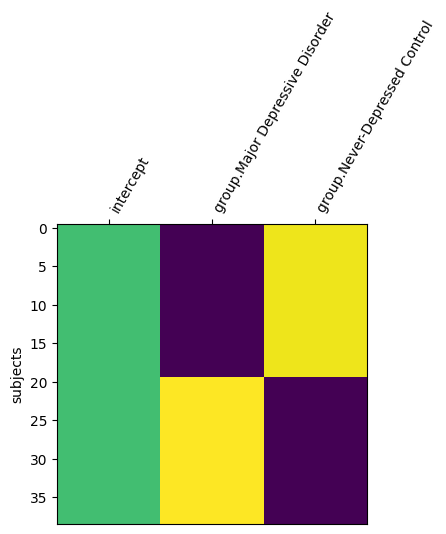

In [204]:
fig, ax = plt.subplots(figsize=(4, .1*len(dataset_outputs[0].X))) 
plot_design_matrix(dataset_outputs[0].X, ax=ax)
ax.set_ylabel("subjects") 
plt.show()

In [177]:
node = model_graph.nodes['data_level']
print(f"  Level: {node.level}")
print(f"  Group by: {node.group_by}")

colls = node.get_collections()
if colls:
    first_coll = colls[0]
    df = first_coll.to_df(entities=True)
    print(df)



  Level: dataset
  Group by: ['contrast']
      subject age                      group sex        suffix
0   control01  19    Never-Depressed Control   F  participants
1   control02  22    Never-Depressed Control   M  participants
2   control03  18    Never-Depressed Control   F  participants
3   control04  19    Never-Depressed Control   M  participants
4   control05  27    Never-Depressed Control   M  participants
5   control06  31    Never-Depressed Control   M  participants
6   control07  31    Never-Depressed Control   F  participants
7   control08  18    Never-Depressed Control   M  participants
8   control09  24    Never-Depressed Control   F  participants
9   control10  23    Never-Depressed Control   F  participants
10  control11  29    Never-Depressed Control   F  participants
11  control12  27    Never-Depressed Control   F  participants
12  control13  22    Never-Depressed Control   F  participants
13  control14  25    Never-Depressed Control   M  participants
14  control15

In [11]:
outputs[1].trans_hist[2].output.to_df().head(50)

IndexError: list index out of range

<Axes: label='conditions', ylabel='scan number'>

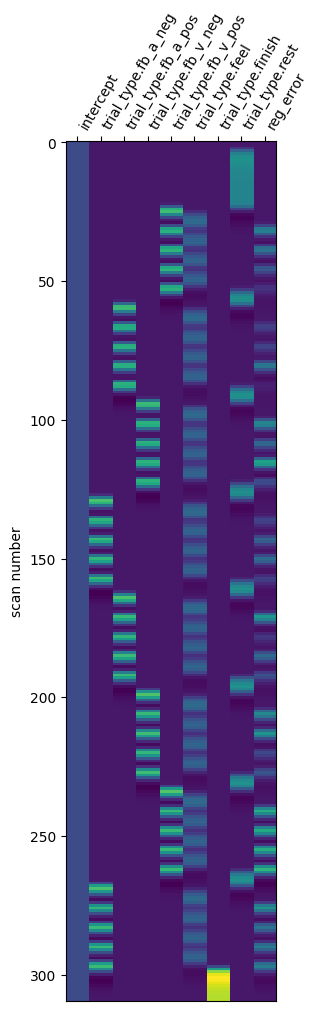

In [14]:
plot_design_matrix(outputs[1].X)

In [16]:
outputs[0].X[outputs[0].X.columns.difference(['intercept'])].corr()

,reg_error,trial_type.fb_a_neg,trial_type.fb_a_pos,trial_type.fb_v_neg,trial_type.fb_v_pos,trial_type.feel,trial_type.finish,trial_type.rest
reg_error,1.000000,0.202479,0.109224,0.307351,0.300299,-0.132728,-0.108967,-0.203481
trial_type.fb_a_neg,0.202479,1.000000,-0.146564,-0.146651,-0.146649,-0.107928,-0.042841,-0.102744
trial_type.fb_a_pos,0.109224,-0.146564,1.000000,-0.157671,-0.147349,-0.115398,-0.074659,-0.080801
trial_type.fb_v_neg,0.307351,-0.146651,-0.157671,1.000000,-0.146913,-0.113100,-0.074573,-0.080173
trial_type.fb_v_pos,0.300299,-0.146649,-0.147349,-0.146913,1.000000,-0.110995,-0.074574,-0.087162
trial_type.feel,-0.132728,-0.107928,-0.115398,-0.113100,-0.110995,1.000000,-0.269878,-0.717231
trial_type.finish,-0.108967,-0.042841,-0.074659,-0.074573,-0.074574,-0.269878,1.000000,-0.094731
trial_type.rest,-0.203481,-0.102744,-0.080801,-0.080173,-0.087162,-0.717231,-0.094731,1.000000


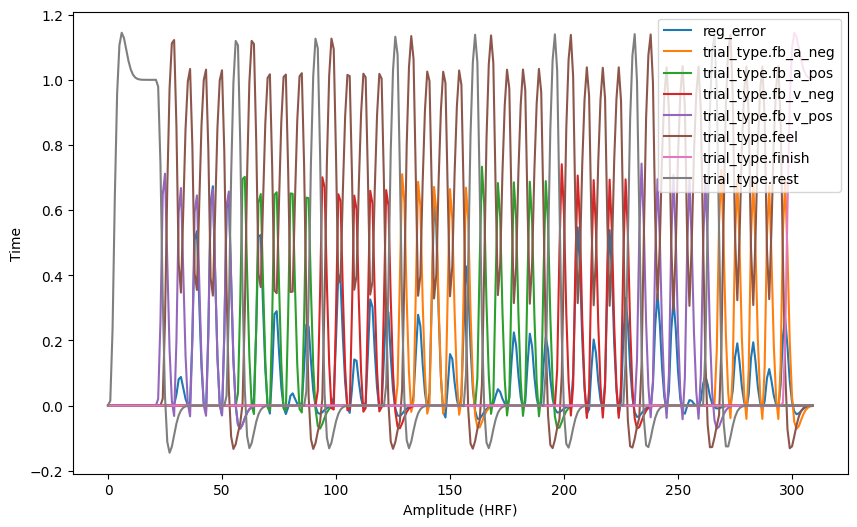

In [15]:
plt.figure(figsize=(10, 6))
data_to_plot = outputs[0].X[0:350]

for i, col in enumerate(outputs[0].X.columns.difference(['intercept'])):
    plt.plot(data_to_plot[col], label=col)

plt.xlabel('Amplitude (HRF)')
plt.ylabel('Time')
plt.legend()
plt.show()

In [7]:
from nilearn.glm.first_level import make_first_level_design_matrix, compute_regressor

In [10]:
frame_times = np.arange(340) * 1.0
frame_times += 2.0 / 2
design_events = outputs[0].trans_hist[0].output.to_df()[['onset','duration','trial_type']]
design_events['amplitude'] = 1
design_matrix_test= make_first_level_design_matrix(
        frame_times=frame_times,
        events=design_events[['onset','duration','trial_type']],
        hrf_model='spm',
        drift_model=None
        )


<Axes: label='conditions', ylabel='scan number'>

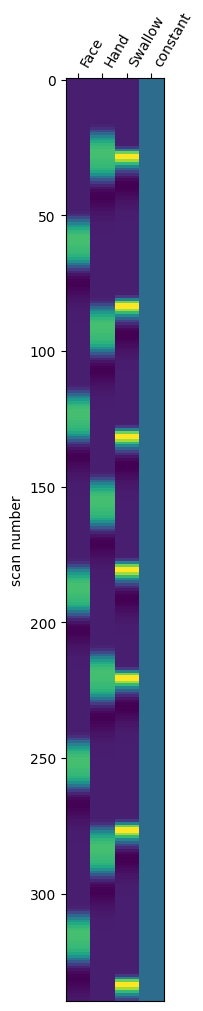

In [11]:
plot_design_matrix(design_matrix_test)

/tmp/ipykernel_3103/2929213114.py:2: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  data_to_plot = design_matrix_test[0:500]


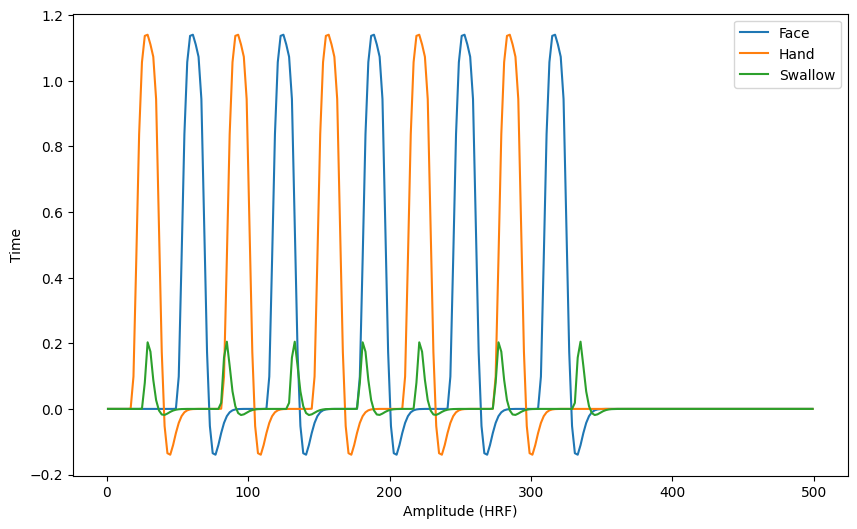

In [35]:
plt.figure(figsize=(10, 6))
data_to_plot = design_matrix_test[0:500]

for i, col in enumerate(design_matrix_test.columns.difference(['constant'])):
    plt.plot(data_to_plot[col], label=col)

plt.xlabel('Amplitude (HRF)')
plt.ylabel('Time')
plt.legend()
plt.show()